## Stateful LSTM Tuning

In the following notebook a simple grid search algorithm developed for the "Predicting Short Term Brent Prices" seminar paper is used on a univariate LSTM model with a lag order of 1 and a batch size of 10. Noteworthy that using the batch size $>1$ when dealing with a stateful LSTM network with lag order of 1 may be technically problematic from the viewpoint of state forwarding but was necessary due to computational and time constraints. 

The actual univariate model fitted as per the parameters obtained from the search will have a batch size of 1, therefore. 

The grid search function used below was improved and wrapped up into a function given in my repository for the [StatefulLSTM wrapper class](https://github.com/anasashb/stateful_lstm_wrapper_for_keras).

**Reproducibility Disclaimer:** The results may not be entirely replicable due to the stochastic nature of optimization, as well as the specifics of GPU-accelerated training.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import stataments, including unused imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.optimizers import Adam
import tensorflow as tf


# Seeds
tf.random.set_seed(66)
np.random.seed(66)

# Plot configurations
plt.rcParams['figure.figsize'] = (12, 6.75)
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 24

# Error metrics
def rmse(true, predicted):
    return np.sqrt(np.mean(np.square(predicted - true)))
def mape(true, predicted):
    true, predicted = np.array(true), np.array(predicted)
    return np.mean(np.abs((true - predicted) / true)) * 100




2023-07-24 20:33:56.922652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


### **Data:**

Note that the dataset used in the notebook is the same as given under the name `univariate_brent.csv` in the repo, but had a different name initially. 

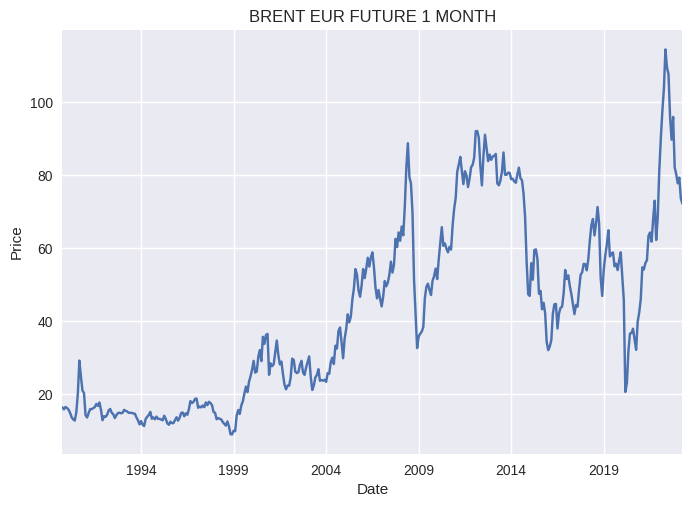

In [2]:
brentpath = '/home/RDC/anasashb/Dokumente/ECXLOC/BRENTDATA.csv'

# Import data set
BRENT = pd.read_csv(brentpath,
                   index_col = 'Date',
                   parse_dates = True)
BRENT = pd.Series(BRENT['EUR Future 1 Month'])

# Plot
BRENT.plot()
plt.title('BRENT EUR FUTURE 1 MONTH')
plt.ylabel('Price')
plt.show()

### Data Preprocessing
As decided in the seminar paper, to make sure the out of sample forecasts would cover the last 80 points of the Brent future price series, test set size of 81 was selected --- which made up roughly $20\%$ of the series. The lengths of the validation and train sets were set at 51 and 271. These lengths made sure that after generating tensors with a lag order of 1, we would end up with the following dimensions:
- X_train, y_train: (270,1,1), (270,1)
- X_val, y_val: (50,1,1), (50,1)
- X_test, y_test: (80,1,1), (80,1)

This would mean that none of the sets would need to be shortened to make sure that the first dimension of the inputs were divisible by the batch size without remainder. 

In [3]:
# Store Date
dates = BRENT.index
# Get values for the series
series = BRENT.values.astype('float32').reshape(-1,1)


In [4]:
# Specify batch_size
batch_size = 10
# Specify lag order
timesteps = 1

In [5]:
# Define test, validation and train sizes
test_size = 81
val_size = 51
train_size = 271
print(test_size+val_size+train_size)

403


In [6]:
# Train-val-test split
train = series[:train_size]
val = series[train_size:train_size+val_size]
test = series[train_size+val_size:]

# Important to obtain the retrain set at this stage
# because we will lose observations if we concatenate 
# the sets after tensors have been generated
retrain = np.concatenate((train, val), axis = 0)

# Check
len(train)+len(val)==len(retrain)



True

In [7]:
# Scale and Generate Tensors

# Scaling: Use (-1,1) for better input to hyperbolic tangent
# Fit on train set
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(train)

# Scale everything per train data parameters
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
retrain = scaler.transform(retrain)

# Reshape as LSTM inputs:
def generate_tensors(series, timesteps):
    
    dataX, dataY = [], []
    
    for i in range(0, len(series) - timesteps):
        x = np.reshape(series[i:i + timesteps], (-1,1))
        dataX.append(x)
        y = series[i +timesteps]
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY)
                 

X_train, y_train = generate_tensors(train, timesteps)
X_val, y_val = generate_tensors(val, timesteps)
X_test, y_test = generate_tensors(test, timesteps)
X_retrain, y_retrain = generate_tensors(retrain, timesteps)

In [8]:
# Check shapes
tensors = [X_train, y_train, X_val, y_val, X_test, y_test, X_retrain, y_retrain]

for i, tensor in enumerate(tensors):
    print(f'{tensor.shape}')

# Remove unneeded variable
del tensors

(270, 1, 1)
(270, 1)
(50, 1, 1)
(50, 1)
(80, 1, 1)
(80, 1)
(321, 1, 1)
(321, 1)


In [9]:
# Double check remainder
remainder = len(y_train) % batch_size
print(remainder)

0


In [11]:
# Check remainder for retrain set
remainder_retrain = len(y_retrain) % batch_size
print(remainder_retrain)

1


In [12]:
# trim the retraining set
X_retrain, y_retrain = X_retrain[remainder_retrain:, :], y_retrain[remainder_retrain:, :]

# Check shapes
print(f'New shape of the training feature and target sets:\n {X_retrain.shape}\n {y_retrain.shape}\n')

New shape of the training feature and target sets:
 (320, 1, 1)
 (320, 1)



### Model Tuning
In the custom gid search, we look for optimal number of layers between $1$ and $5$, and within each layer for optimal amount of neurons, between $5$ and $50$.

Just to be on the safe side and be able to track everything, two criterions are selected for tracking validation loss: `last` and `min`. The former looks at the validation loss achieved at the very last epoch of the training, while the latter looks at the minimum loss achieved throughout training. 

In [17]:
# Best parameters' placeholders
best_val_loss_min = float("inf")
best_units_min = None
best_num_layers_min = None

best_val_loss_last = float("inf")
best_units_last = None
best_num_layers_last = None



# Iterate
# Select how many layers to go through
for num_layers in range(1, 6):
    for units in range(5, 55, 5):
        print(f"New trial with {num_layers} layers, {units} units")

        #Set up model parameters
        model = Sequential()
        for i in range(num_layers):
            model.add(LSTM(units,
                           activation = 'tanh',
                           recurrent_activation = 'sigmoid',
                           kernel_regularizer = regularizers.L2(1e-3),
                           recurrent_regularizer = regularizers.L2(1e-3),
                           bias_regularizer = regularizers.L2(1e-3),
                           recurrent_dropout = 0,
                           unroll = False,
                           use_bias = True,
                           stateful=True,
                           return_sequences=True if i < num_layers - 1 else False,
                           batch_input_shape=(batch_size, timesteps, 1)))
            model.add(Dropout(0.1))  
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Set up empty container for losses
        train_losses = []
        val_losses = []

        # Stateful training loop: 
        for epoch in range(100):
            print(f"Starting epoch {epoch+1} for current trial", end="\r")
            history = model.fit(X_train,
                                y_train,
                                epochs = 1,
                                batch_size = batch_size,
                                verbose = 0)
            # Reset cell states after one epoch
            model.reset_states()
            
            # Calculate validation losses
            val_loss = model.evaluate(X_val, y_val, batch_size = batch_size, verbose = 0)
            
            # Append losses
            train_losses.append(history.history['loss'])
            val_losses.append(val_loss)
        
        final_val_loss_last = val_losses[-1]
        final_val_loss_min = min(val_losses)

        # Check if this set of hyperparameters gives a lower validation loss
        if final_val_loss_last < best_val_loss_last:
            best_val_loss_last = final_val_loss_last
            best_units_last = units
            best_num_layers_last = num_layers
            print(f"\nLast Criterion: New best parameters found. Layers: {best_num_layers_last}, Units: {best_units_last}, Val_loss: {best_val_loss_last}")
        else:
            print(f'\nLast Criterion: No new best parameters found at the stage. Moving on...')
        
        if final_val_loss_min < best_val_loss_min:
            best_val_loss_min = final_val_loss_min
            best_units_min = units
            best_num_layers_min = num_layers
            print(f"Min Criterion: New best parameters found. Layers: {best_num_layers_min}, Units: {best_units_min}, Val_loss: {best_val_loss_min}")
        else:
            print(f'Min Criterion: No new best parameters found at the stage. Moving on...')
        print("=" * 100)

print(f"\nSearch finished.")
print("=" * 100)
print('Last loss criterion results:')
print(f"Best number of layers: {best_num_layers_last}")      
print(f"Best number of units: {best_units_last}")
print(f"Best validation loss achieved: {best_val_loss_last}")
print("=" * 100)
print('Minimum loss criterion results:')
print(f"Best number of layers: {best_num_layers_min}")      
print(f"Best number of units: {best_units_min}")
print(f"Best validation loss achieved: {best_val_loss_min}")


New trial with 1 layers, 5 units


2023-07-24 20:37:15.605568: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-24 20:37:15.606981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-24 20:37:15.619589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.48GiB deviceMemoryBandwidth: 581.23GiB/s
2023-07-24 20:37:15.619852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.48GiB deviceMemoryBandwidth: 581.23GiB/s
2023-07-24 20:37:15.619885: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-24 20:3

2023-07-24 20:37:17.782872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-24 20:37:17.783327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100000000 Hz
2023-07-24 20:37:18.671706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-24 20:37:19.076211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Starting epoch 100 for current trial
Last Criterion: New best parameters found. Layers: 1, Units: 5, Val_loss: 0.022462595254182816
Min Criterion: New best parameters found. Layers: 1, Units: 5, Val_loss: 0.022462595254182816
New trial with 1 layers, 10 units
Starting epoch 100 for current trial
Last Criterion: New best parameters found. Layers: 1, Units: 10, Val_loss: 0.020016297698020935
Min Criterion: New best parameters found. Layers: 1, Units: 10, Val_loss: 0.02000487968325615
New trial with 1 layers, 15 units
Starting epoch 100 for current trial
Last Criterion: New best parameters found. Layers: 1, Units: 15, Val_loss: 0.0185603778809309
Min Criterion: New best parameters found. Layers: 1, Units: 15, Val_loss: 0.0185603778809309
New trial with 1 layers, 20 units
Starting epoch 100 for current trial
Last Criterion: New best parameters found. Layers: 1, Units: 20, Val_loss: 0.018352609127759933
Min Criterion: New best parameters found. Layers: 1, Units: 20, Val_loss: 0.018298652023

### Results:
The two criterions gave different configurations. We decide to go with 1 layer and 45 units, as the minimum loss is what widely used Keras-Tuner package also tracks. Besides, since we will be using early stopping when actually fitting the models with restoring best weights, it is more sound to go with the configuration that gave the minimum loss. 